# Validation Set 1.2: diffuPy + PathMe  

In [1]:
import os
import itertools

import time
import copy

dir_path = os.path.dirname(os.path.realpath('__file__'))

In [2]:
from openpyxl import load_workbook
from collections import defaultdict
import networkx as nx

In [3]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction


pybel.get_version()

'0.13.2'

In [4]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

In [5]:
from diffuPy.diffuse import diffuse
from diffuPy.kernels import regularised_laplacian_kernel
from diffuPy.matrix import Matrix, LaplacianMatrix
from diffuPy.input_mapping import generate_categoric_input_from_labels, get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffuPy.validation_sets_utils import parse_set1
from diffuPy.utils import print_dict_dimentions, get_labels_set_from_dict, reduce_dict_dimention
from diffuPy.views import show_heatmap

from diffuPy.miscellaneous import get_label_list_graph


In [6]:
# TODO
import nbimporter
from global_database_comparison import get_set_database, calculate_database_sets_as_dict

Importing Jupyter notebook from global_database_comparison.ipynb


## 1. Load Data Set 1: Input Scores

In [7]:
dataset1_labels_by_omics = parse_set1(os.path.join(dir_path, 'validation', 'set1.xlsx'))

In [8]:
print_dict_dimentions(dataset1_labels_by_omics, 'Dataset1 imported labels:')

Dataset1 imported labels:
Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [9]:
dataset1_all_labels = get_labels_set_from_dict(dataset1_labels_by_omics)

## 2. Load Backrgound Graph Universe

### 2.1. PathMeUniverse import

##### Database argument in node data

In [10]:
pathme_graph_universe_no_explode = pybel.from_pickle(os.path.join(PATHME_DIR, 'universe', 'pathme_universe_bel_graph.bel.pickle'))



In [11]:
pathme_graph_universe_no_explode.summarize()

PathMe Universe v1.0.0
Number of Nodes: 24200
Number of Edges: 87599
Number of Citations: 7038
Number of Authors: 0
Network Density: 1.50E-04
Number of Components: 14123
Number of Warnings: 0


##### Export to gml

In [12]:
to_gml(pathme_graph_universe_no_explode, os.path.join(PATHME_DIR, 'pathme_graph_universe_no_explode.gml'))

In [13]:
g = nx.read_gml(os.path.join(PATHME_DIR, 'pathme_graph_universe_no_explode.gml'))

In [14]:
nx.info(g)

'Name: \nType: MultiDiGraph\nNumber of nodes: 24061\nNumber of edges: 87599\nAverage in degree:   3.6407\nAverage out degree:   3.6407'

##### Check isolates / Unconnected nodes

In [15]:
isolates = list(nx.isolates(g))

#import json
#with open(os.path.join(PATHME_DIR, 'isolates.json'), 'w') as outfile:
#    d = json.dump(isolates, outfile)

print(len(isolates))
#list(nx.isolates(pathme_graph_universe_no_explode))

13550


In [16]:
pathme_graph_universe_no_explode.remove_nodes_from({
    node
    for node in nx.isolates(pathme_graph_universe_no_explode)
})

In [17]:
nx.number_of_isolates(pathme_graph_universe_no_explode)

0

### 2.1. Get labels subsets by entity type (omic) and database

##### PathMe package subsets

In [18]:
def get_labels_by_db_and_omic_from_pathme(databases):
    db_entites = defaultdict(dict)
    entites_db = defaultdict(lambda: defaultdict(set))
    
    for db in databases:
        genes, mirna, metabolites, bps = get_set_database(db)
        db_entites[db] = {'genes': genes, 'mirna': mirna, 'metabolites': metabolites, 'bps': bps}
        
        for entity_type, entities in db_entites[db].items():
            entites_db[entity_type][db] = entities
            
    return db_entites, entites_db

In [19]:
bg_labels_from_pathme_by_db_and_omic, bg_labels_from_pathme_by_omic_and_db = get_labels_by_db_and_omic_from_pathme(['reactome', 'kegg', 'wikipathways'])

print_dict_dimentions(bg_labels_from_pathme_by_db_and_omic, 'Entities in PathMe package :')



Entities in PathMe package :
Total number of reactome: genes(8653), mirna(13), metabolites(2712), bps(2219),  
Total number of kegg: genes(7656), mirna(149), metabolites(4421), bps(418),  
Total number of wikipathways: genes(3361), mirna(91), metabolites(657), bps(135),  
Total: 30485 


In [20]:
bg_labels_from_pathme_by_omic = reduce_dict_dimention(bg_labels_from_pathme_by_omic_and_db)
mirnas = bg_labels_from_pathme_by_omic['mirna']

#####  PathMeUniverse Graph Subsets

In [21]:
def get_labels_by_db_and_omic_from_graph(graph):
    
    db_subsets_pmu = defaultdict(set)
    db_entites_pmu = defaultdict(dict)

    #entity_type_map = {'Gene':'genes', 'mirna_nodes':'mirna', 'Abundance':'metabolites', 'BiologicalProcess':'bps'}

    for u, v, k in graph.edges(keys=True):
        if ANNOTATIONS not in graph[u][v][k]:
            continue
            
        if 'database' not in graph[u][v][k][ANNOTATIONS]:
            continue
            
        for database in graph[u][v][k][ANNOTATIONS]['database']:
            db_subsets_pmu[database].add(u)
            db_subsets_pmu[database].add(v)
        
    for database, nodes in db_subsets_pmu.items():
        db_entites_pmu[database] = calculate_database_sets_as_dict(nodes, database)
        
    return db_entites_pmu, db_subsets_pmu

In [22]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_graph_universe_no_explode)

print_dict_dimentions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')


Entities in PathMeUniverse :
Total number of kegg: gene_nodes(5862), mirna_nodes(122), metabolite_nodes(1720), bp_nodes(112),  
Total number of reactome: gene_nodes(1494), mirna_nodes(5), metabolite_nodes(268), bp_nodes(0),  
Total number of wikipathways: gene_nodes(2260), mirna_nodes(91), metabolite_nodes(434), bp_nodes(123),  
Total: 12491 


###  Subgraphs 

In [23]:
# TODO
# def get_subgraphs_by_entity(graph: BELGraph) -> dict:
#     entities_types = ['genes', 'mirna', 'metabolites', 'bps']
#     subgraphs = {}
    
#     for entities_type in entities_types:
#         subgraphs[entities_type] = pbt.selection.get_subgraph_by_node_filter(graph, function=entities_type, value=f'PathME {entities_type}' )

#     return subgraphs

# get_subgraphs_by_entity(pathme_graph_universe_no_explode)

# TODO
#def get_subgraphs_by_resource(graph: BELGraph) -> None:

### Background  Matrix

In [24]:
then = time.time()

In [25]:
background_mat = regularised_laplacian_kernel(pathme_graph_universe_no_explode)

/Users/jmarinllao/Documents/CREB/diffuPy/src/diffuPy/miscellaneous.py:19: UserWarning: Graph must be undirected, so it is converted to undirected.
  warnings.warn('Graph must be undirected, so it is converted to undirected.')
Columns labels are assigned to rows since duplicate labels is true.


In [26]:
now = time.time()
print("It took: ", now-then, " seconds")

It took:  65.79601621627808  seconds


### Row labels

In [27]:
background_labels = background_mat.rows_labels

In [28]:
mirnas = dataset1_labels_by_omics['micrornas']

## 3. Dataset label mapping to PathMeEntities

### General mapping

In [29]:
all_labels_mapping = get_mapping(dataset1_all_labels, background_labels, title = 'Global mapping: ', mirnas=mirnas, print_percentage = True)


Global mapping:  (1851) 36.5665744764915%


### Mapping by subsets

#### Mapping by entity type/omic

In [30]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset1_labels_by_omics, background_labels, 'entity type/omic', mirnas=mirnas)


Mapping by entity type/omic:
genes (1834) 37.11799230924914%
micrornas (11) 11.0%
metabolite (28) 133.33333333333331%
Total (1851) 36.5665744764915% 



In [31]:
micrornas_mapping = mapping_by_entity['micrornas'][0]
micrornas_mapping

{'mir106b',
 'mir140',
 'mir183',
 'mir193b',
 'mir222',
 'mir27b',
 'mir30b',
 'mir30e',
 'mir32',
 'mir34a',
 'mir421'}

#### Mapping by database

In [32]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset1_all_labels, 'database', mirnas=mirnas, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (1605) 31.706835242986962%
reactome (197) 3.891742394310549%
wikipathways (693) 13.690241011457921%
Total (1851) 36.5665744764915% 



#### Mapping by entity type and database

In [33]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset1_all_labels, relative_statistics = dataset1_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (1589) 32.15948188625784%
mirna_nodes (8) 8.0%
metabolite_nodes (8) 38.095238095238095%
bp_nodes (0) 0%
Total (1605) 20.534800409416583% 

Mapping by Reactome:
gene_nodes (197) 3.9870471564460637%
mirna_nodes (0) 0.0%
metabolite_nodes (0) 0.0%
bp_nodes (0) 0%
Total (197) 11.155152887882219% 

Mapping by Wikipathways:
gene_nodes (669) 13.539769277474194%
mirna_nodes (8) 8.0%
metabolite_nodes (17) 80.95238095238095%
bp_nodes (0) 0%
Total (693) 23.84721266345492% 

Total (1851) 36.5665744764915% 



### Mapping descriptive view

In [50]:
# TODO

all_count = []
all_percentage = []

entity_type_map = {'metabolite_nodes': 'metabolite', 'mirna_nodes': 'micrornas', 'gene_nodes': 'genes',
                    'bp_nodes': 'bps'}

for db_name, entities_by_type in mapping_by_database_and_entity.items():
    db_count = []
    db_percentage = []

    for entity_type, entities_tupple in entities_by_type[0].items():
        db_count.append(len(entities_tupple[0]))
        db_percentage.append(entities_tupple[1])
        
        
    all_count.append(db_count)
    all_percentage.append(db_percentage)

db_count = []
db_percentage = []
for entity, entities_tupple in mapping_by_entity.items():
    db_count.append(len(entities_tupple[0]))
    db_percentage.append(entities_tupple[1])
    


In [51]:
import numpy as np

databases = list(mapping_by_database_and_entity.keys())
databases.append('arreu')


entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

In [52]:
databases = mapping_by_database_and_entity.keys()
entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

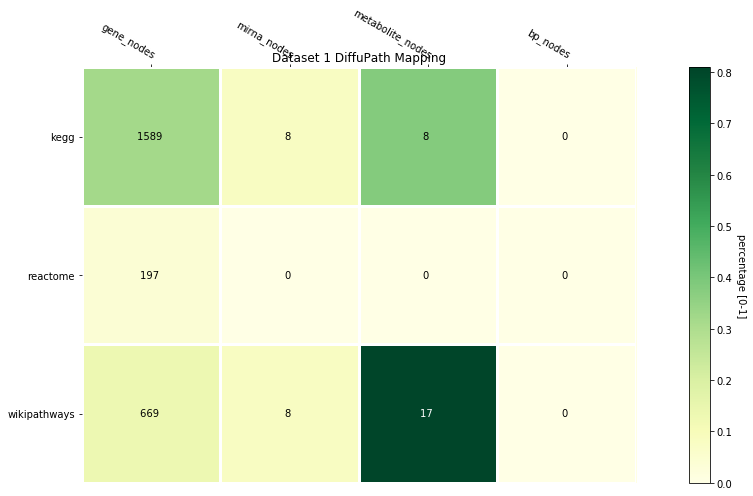

In [53]:
show_heatmap(entity_number, entity_count, databases, entity_types)

## 4. Score Diffusion with diffuPy: Dataset as input + PathMe as background graph

### Input elements: Dataset input + Background matrix

#### Input vector/matrix construction

In [54]:
input_mats_by_entity_type = {entity_type: generate_categoric_input_from_labels(all_labels_mapping, ['Dataset 1'], background_mat) for entity_type, map_value in mapping_by_entity.items()}
input_mat = generate_categoric_input_from_labels(all_labels_mapping, ['Dataset 1'], background_mat)


In [55]:
input_mat_raw = copy.copy(input_mat)
background_mat_raw = copy.copy(background_mat)

input_mat_z = copy.copy(input_mat)
background_mat_z = copy.copy(background_mat)

Columns labels are assigned to rows since duplicate labels is true.
Columns labels are assigned to rows since duplicate labels is true.


### Compute diffusion scores

#### Raw scores

In [56]:
then = time.time()

In [57]:
raw_scores = diffuse(input_mat_raw, 'ml', K = background_mat_raw)

In [58]:
now = time.time()
print("It took: ", now-then, " seconds")

It took:  0.24445700645446777  seconds


In [59]:
print(raw_scores)


matrix  
  [[-0.67252376]
 [-0.69093874]
 [-0.37017266]
 ...
 [-0.375     ]
 [-0.35893475]
 [-0.3097046 ]] 
 row labels: 
  ['cob(iii)alamin', 'calhm1', 'cyp51a1', 'naca', 'nfatc2', 'sdha', 'mapk8ip3', 'sav1', 'itpkb', 'bmp8b', 'cxcl3', '5-amino-1-(5-phospho-beta-d-ribosyl)imidazole', 'cxxc1 gene', 'reactive oxygen species generators', 'boc', 'vapb', 'ub c-terminal hh fragments', 'reps2', 'snai1', 'efna2', 'k48polyub-k21', 'udp-d-galactose', 'gl:g00108', 'matk', 'naphthalene-1,2-diol', 'gart', 'pitpna', 'klf10', 'ppp3ca', 'gl:g00147', 'ran', 'or52d1', 'htr3d', 'csnk2a1', 'arhgef26', 'pdgfb', 'angiotensin iv', 'phkb', 'map3k3', 'heyl', '3,17-dioxoandrost-4-en-19-al', 'srsf3', 'tac4', 'apc', 'peptidoglycan biosynthesis', '6274', 'mat1a', 'gadd45a gene', 'atf6', 'gl:g00036', 'erlotinib', 'ptpn genes13', 'dopaminochrome', 'pde7b', 'gl:g00111', 'fads1', 'cldn16', 'open)', 'pcbd1', 'pip4k2b', 'polyub-p-nicd4', 'gng7', 'acsf3', 'or52k1', 'mlh1 gene', 'mcm5', 'shc3', 'xcr1', 'rb1cc1', '1,8-ci

#### Normalized z-scores

In [60]:
then = time.time()

In [61]:
z_scores = diffuse(input_mat_z, 'ml', K = background_mat_z, z = True)

/Users/jmarinllao/Documents/CREB/diffuPy/src/diffuPy/diffuse_raw.py:44: RuntimeWarning: invalid value encountered in true_divide
  return np.subtract(col_raw, score_means) / np.sqrt(score_vars)


In [62]:
now = time.time()
print("It took: ", now-then, " seconds")

It took:  1.4664771556854248  seconds


In [63]:
print(z_scores)


matrix  
  [[-0.35565186]
 [-0.16543325]
 [ 2.09775601]
 ...
 [-0.63992987]
 [ 0.22773448]
 [ 0.27396376]] 
 row labels: 
  ['cob(iii)alamin', 'calhm1', 'cyp51a1', 'naca', 'nfatc2', 'sdha', 'mapk8ip3', 'sav1', 'itpkb', 'bmp8b', 'cxcl3', '5-amino-1-(5-phospho-beta-d-ribosyl)imidazole', 'cxxc1 gene', 'reactive oxygen species generators', 'boc', 'vapb', 'ub c-terminal hh fragments', 'reps2', 'snai1', 'efna2', 'k48polyub-k21', 'udp-d-galactose', 'gl:g00108', 'matk', 'naphthalene-1,2-diol', 'gart', 'pitpna', 'klf10', 'ppp3ca', 'gl:g00147', 'ran', 'or52d1', 'htr3d', 'csnk2a1', 'arhgef26', 'pdgfb', 'angiotensin iv', 'phkb', 'map3k3', 'heyl', '3,17-dioxoandrost-4-en-19-al', 'srsf3', 'tac4', 'apc', 'peptidoglycan biosynthesis', '6274', 'mat1a', 'gadd45a gene', 'atf6', 'gl:g00036', 'erlotinib', 'ptpn genes13', 'dopaminochrome', 'pde7b', 'gl:g00111', 'fads1', 'cldn16', 'open)', 'pcbd1', 'pip4k2b', 'polyub-p-nicd4', 'gng7', 'acsf3', 'or52k1', 'mlh1 gene', 'mcm5', 'shc3', 'xcr1', 'rb1cc1', '1,8-ci